# DFL - Decision-Focused Learning for VRPs
## Using SPO+

In [1]:
from util import parse_datafile
import torch
import numpy as np
import torch.nn as nn
from solver import GurobiSolver

In [2]:
def spo_plus_forward(pred_costs, vrp):
    solver = GurobiSolver(vrp)
    solver.set_spo_objective()
    solver.solve()

    loss = solver.get_obj_val() + 2 * torch.dot(pred_costs, torch.FloatTensor(vrp.actual_solution)) - vrp.actual_obj
    loss = torch.FloatTensor(np.array(loss)).to(pred_costs.device)

    predicted_solution = torch.FloatTensor(np.array(solver.get_decision_variables())).to(pred_costs.device)

    return loss, predicted_solution

class SPOplusFunction(torch.autograd.Function):
    """
    The SPO+ function as described in the paper Smart “Predict, then Optimize" https://arxiv.org/abs/1710.08005
    """

    @staticmethod
    def forward(ctx, pred_costs, vrp):
        loss, predicted_solution = spo_plus_forward(pred_costs, vrp)
        ctx.save_for_backward(torch.FloatTensor(vrp.actual_solution).to(pred_costs.device), predicted_solution)
        return loss

    @staticmethod
    def backward(ctx, grad_loss):
        actual_solution, predicted_solution = ctx.saved_tensors
        return grad_loss * 2 * (actual_solution - predicted_solution), None, None


class SPOplus(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.spoPlusFunction = SPOplusFunction()

    def forward(self, *args):
        return self.spoPlusFunction.apply(*args)


class CostPredictor(torch.nn.Module):
    """
    A simple neural network that predicts the edge costs of a VRP.

    The input is a vector of edge features, the output is a vector of edge costs.
    """

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # self.fc = nn.Linear(input_size, output_size)
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.fc(x)


In [3]:
vrps_train = [parse_datafile(f'../data/v3_1000_10_5_4/instance_{i}') for i in range(800)]
vrps_test = [parse_datafile(f'../data/v3_1000_10_5_4/instance_{i}') for i in range(800, 1000)]

In [4]:
# solve the VRPs with the actual edge costs and save the solutions
for vrp in vrps_train:
    if vrp.actual_solution is not None:
        continue
    solver = GurobiSolver(vrp)
    solver.solve()
    vrp.actual_solution = solver.get_decision_variables()
    vrp.actual_obj = solver.get_obj_val()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-16
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter

In [5]:
num_edges = len(vrps_train[0].edges)
num_features = len(vrps_train[0].edges[0].features)

cost_model = CostPredictor(num_edges * num_features, num_edges, num_edges)
optimizer = torch.optim.Adam(cost_model.parameters(), lr=8e-3)
spo_plus = SPOplus()

# training
num_epochs = 20
for epoch in range(num_epochs):
    mean_loss = 0
    for vrp in vrps_train:
        optimizer.zero_grad()
        # get the edge features
        edge_features = torch.tensor([edge.features for edge in vrp.edges], dtype=torch.float32).view(-1)
        # predict the edge costs
        predicted_edge_costs = cost_model(edge_features)
        # set the predicted edge costs
        for i, edge in enumerate(vrp.edges):
            edge.predicted_cost = predicted_edge_costs[i]
        # calculate the loss
        loss = spo_plus(predicted_edge_costs, vrp).mean()
        # backpropagation
        loss.backward()
        optimizer.step()
        mean_loss += loss.item()
    mean_loss /= len(vrps_train)

    print("\n----------------------------------------------------------")
    print(f'Epoch {epoch + 1} / {num_epochs} done, mean_loss: {mean_loss}')
    print("----------------------------------------------------------\n")

Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Set para

Set parameter MIPGap to value 0


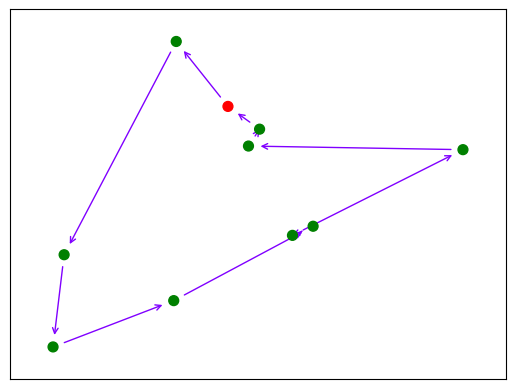

In [8]:
from util import draw_solution

# testing
# test = vrps_train[0]
test = vrps_test[0]

solver = GurobiSolver(test)
solver.solve()
draw_solution(solver)

Set parameter MIPGap to value 0


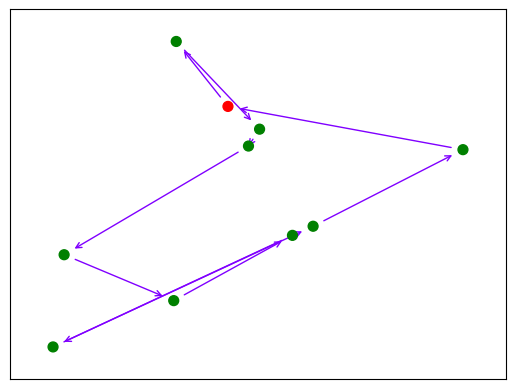

In [9]:
edge_features = torch.tensor([edge.features for edge in test.edges], dtype=torch.float32)
edge_features = edge_features.view(-1)
predicted_edge_costs = cost_model(edge_features)
for i, edge in enumerate(test.edges):
    edge.predicted_cost = predicted_edge_costs[i]
solver = GurobiSolver(test)
solver.set_predicted_objective()
solver.solve()
draw_solution(solver)

In [10]:
# test
regret = 0.0
accuracy = 0.0
actual_sols_cost = 0.0
predicted_sols_cost = 0.0

for vrp in vrps_test:
    solver = GurobiSolver(vrp)
    solver.solve()
    actual_obj = solver.get_obj_val()
    actual_edges = solver.get_active_arcs()
    actual_costs = [edge.cost for edge in vrp.edges]
    actual_sols_cost += actual_obj
    predicted_edge_costs = cost_model(torch.tensor([edge.features for edge in vrp.edges], dtype=torch.float32).view(-1))
    for i, edge in enumerate(vrp.edges):
        edge.predicted_cost = predicted_edge_costs[i]
    solver = GurobiSolver(vrp)
    solver.set_predicted_objective()
    solver.solve()
    predicted_edges = solver.get_active_arcs()
    predicted_obj = np.dot(actual_costs, solver.get_decision_variables())
    predicted_sols_cost += predicted_obj
    regret += predicted_obj - actual_obj
    correct_edges = set(actual_edges).intersection(predicted_edges)
    incorrect_edges = set(actual_edges).symmetric_difference(predicted_edges)
    accuracy += float(len(correct_edges)) / float((len(correct_edges) + len(incorrect_edges)))
    print(f'Parsed instance {vrp}, accuracy: {accuracy}, actual cost: {actual_sols_cost}, predicted cost: {predicted_sols_cost}')
print(f'Regret: {regret/len(vrps_test)}, accuracy: {accuracy/len(vrps_test)}, cost comparison: {predicted_sols_cost / actual_sols_cost}')

Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Parsed instance VRP instance: ../data/v3_1000_10_5_4/instance_800, accuracy: 0.05263157894736842, actual cost: 2342.9581046168, predicted cost: 6363.80493745339
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Parsed instance VRP instance: ../data/v3_1000_10_5_4/instance_801, accuracy: 0.22910216718266255, actual cost: 4746.345548910722, predicted cost: 9123.78889005549
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Parsed instance VRP instance: ../data/v3_1000_10_5_4/instance_802, accuracy: 0.281733746130031, actual cost: 7738.358610056992, predicted cost: 17166.404086240844
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Parsed instance VRP instance: ../data/v3_1000_10_5_4/instance_803, accuracy: 0.531733746130031, actual cost: 11604.914267029826, predicted cost: 24214.46848187447
Set parameter MIPGap to value 0
Set parameter MIPGap to value 0
Parsed instance VRP instance: 